In [1]:
import torch
import numpy as np
from diff_trainer import extract
from matplotlib import pyplot as plt
import diffusers
import os
from fucs import save_image
import fucs
from coders import cal_acc
from diffusers import UNet2DConditionModel
import Unetwork
import diff_trainer
import config
%load_ext autoreload
%autoreload 1
%aimport config
%aimport fucs
modelconfig = config.vscodeconfig

f:\Anaconda\envs\nc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current platform:  nt


In [2]:
print(modelconfig['eval_load_weight'])
with torch.no_grad():
    device = torch.device(modelconfig['device'])
    model = UNet2DConditionModel(
        sample_size=32,
        in_channels=1,            # Stable Diffusion 的 latent 空间通道数
        out_channels=1,
        block_out_channels=(128, 256, 512, 512),
        cross_attention_dim=10,  # 条件嵌入的维度（如文本编码的 hidden_size）
        attention_head_dim=8,     # 注意力头数
    )
    ckpt = torch.load(
        os.path.join(modelconfig['save_weight_dir'], modelconfig['eval_load_weight']),
        map_location=device
    )
    model.load_state_dict(ckpt)
    model.to(device)
    model.eval()

ckpt99_.pt


In [3]:
target_data_list = []
target_file_dir = modelconfig["hr_path"]
target_file_list = os.listdir(target_file_dir)
for file in target_file_list:
    file_path = os.path.join(target_file_dir, file)
    data = np.load(file_path, allow_pickle=True)#276,64,64
    target_data_list.append(data)

target_data = torch.from_numpy(np.stack(target_data_list).astype(np.float32))#189,274,32,32
target_data = torch.unsqueeze(target_data, dim=2)
target_data = target_data.view(-1, 1, 32, 32)#51786,1,32,32

model_file_dir = modelconfig["lr_path"]
model_file_list = os.listdir(model_file_dir)
assert model_file_list == target_file_list, '顺序完全一致！'
if model_file_list == target_file_list:
    print("顺序完全一致！")
model_data_list = []
for file in model_file_list:
    file_path = os.path.join(model_file_dir, file)
    data = np.load(file_path, allow_pickle=True)#274,10,32,32
    model_data_list.append(data)
condition = torch.from_numpy(np.stack(model_data_list).astype(np.float32))#189,274,10,32,32
condition = condition.view(-1, 10, 32, 32)#51786,10,32,32

顺序完全一致！


In [ ]:
less = 0
for i in range(target_data.shape[0]):
    x0 = target_data[i:i+1]
    if torch.any(x0 > 1):
        less += 1
    save_image(x0, names=['x0_'+str(i)], show=True)
print(less)

torch.Size([1, 1, 32, 32]) torch.Size([1, 10, 32, 32])
tensor(0.0389) tensor(0.1433)


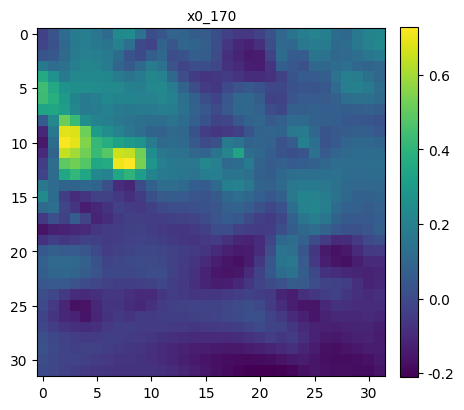

In [4]:
show_which = 170
x0 = target_data[show_which:show_which+1]
condition0 = condition[show_which:show_which+1]
encoder_hidden_states = condition0.flatten(2).permute(0, 2, 1).to(device)
encoder_hidden_states0 = torch.ones_like(encoder_hidden_states, device=device)
print(x0.shape, condition0.shape)
print(x0.nanmean(), x0.std())
save_image(x0, names=['x0_'+str(show_which)], show=True)



In [ ]:
save_image(condition0[0, 0], condition0[0, 1], condition0[0, 2], condition0[0, 3], show=True)
save_image(condition0[0, 4], condition0[0, 5], condition0[0, 6], condition0[0, 7], show=True)
save_image(condition0[0, 8], condition0[0, 9], show=True)

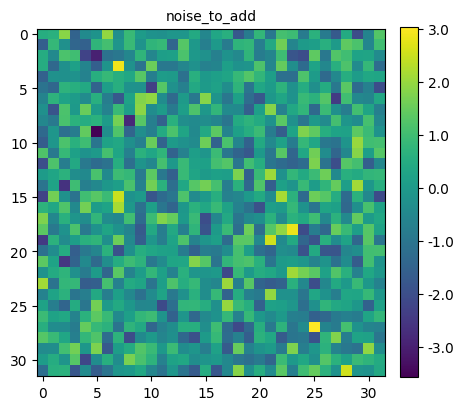

In [8]:
ddim_sch = diffusers.schedulers.scheduling_ddim.DDIMScheduler(num_train_timesteps=200, beta_schedule='squaredcos_cap_v2', clip_sample=False)
# ddim_sch.to(device)
# t = 199
g = 4
ddim_sch.set_timesteps(100)
x0 = torch.nan_to_num(x0, nan=0.0).to(device)

inf_image_list = []
current_batch_size = 50
# torch.manual_seed(42)
# noise_to_add = torch.randn((1,1,32,32), device=device).repeat(50,1,1,1)
noise_to_add = torch.randn((current_batch_size,1,32,32), device=device)
save_image(noise_to_add[3], names=['noise_to_add'], show=True)
# xt = ddim_sch.add_noise(x0.float(), noise_to_add, torch.tensor([199], device=device))
inf_image = noise_to_add
# save_image(inf_image, names=['xt'], show=True)
with torch.no_grad():
    for t in ddim_sch.timesteps:
        t = t.to(device)
        eps = model(inf_image, t, encoder_hidden_states.expand(current_batch_size, -1, -1)).sample
        eps1 = model(inf_image, t, encoder_hidden_states0.expand(current_batch_size, -1, -1)).sample
        total_eps = eps1 + g * (eps - eps1)
        inf_image = ddim_sch.step(total_eps, t, inf_image, eta=0.0)[0]
# 直接存到大tensor
# all_samples[0:0+current_batch_size] = inf_image.detach()

In [9]:
acclist = []
for i in range(current_batch_size):
    acc = fucs.cal_acc(inf_image[i], x0[0])
    print(i, 'acc:', acc)
    acclist.append(float(acc))

0 acc: tensor([0.0711], device='cuda:0')
1 acc: tensor([-0.4808], device='cuda:0')
2 acc: tensor([0.0988], device='cuda:0')
3 acc: tensor([0.1350], device='cuda:0')
4 acc: tensor([0.1375], device='cuda:0')
5 acc: tensor([0.6690], device='cuda:0')
6 acc: tensor([0.0327], device='cuda:0')
7 acc: tensor([-0.0161], device='cuda:0')
8 acc: tensor([-0.1715], device='cuda:0')
9 acc: tensor([-0.2215], device='cuda:0')
10 acc: tensor([-0.0384], device='cuda:0')
11 acc: tensor([0.0220], device='cuda:0')
12 acc: tensor([0.0246], device='cuda:0')
13 acc: tensor([-0.0034], device='cuda:0')
14 acc: tensor([-0.0141], device='cuda:0')
15 acc: tensor([-0.2656], device='cuda:0')
16 acc: tensor([-0.0672], device='cuda:0')
17 acc: tensor([-0.0523], device='cuda:0')
18 acc: tensor([-0.0920], device='cuda:0')
19 acc: tensor([-0.0379], device='cuda:0')
20 acc: tensor([-0.1858], device='cuda:0')
21 acc: tensor([-0.1285], device='cuda:0')
22 acc: tensor([-0.2809], device='cuda:0')
23 acc: tensor([0.5095], devi

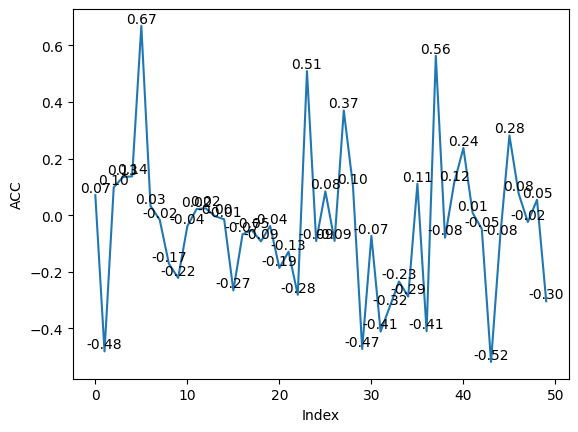

: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acclist)
plt.xlabel('Index')
plt.ylabel('ACC')
for i, acc in enumerate(acclist):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')
# 显示图表
plt.show()

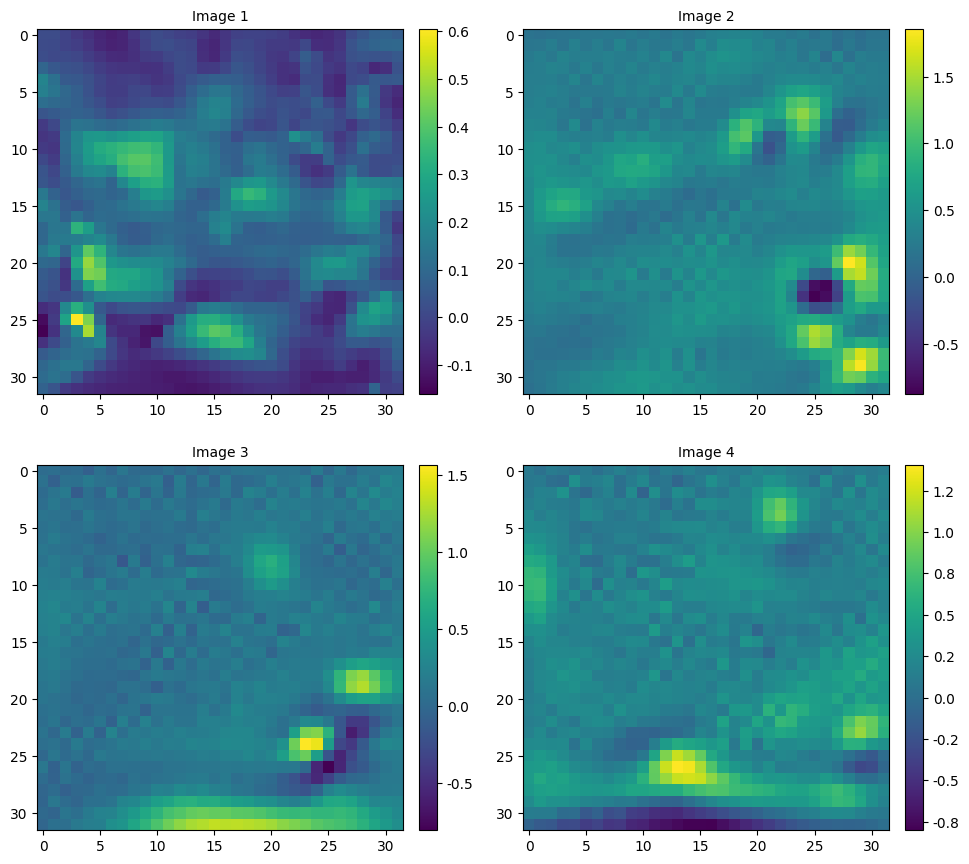

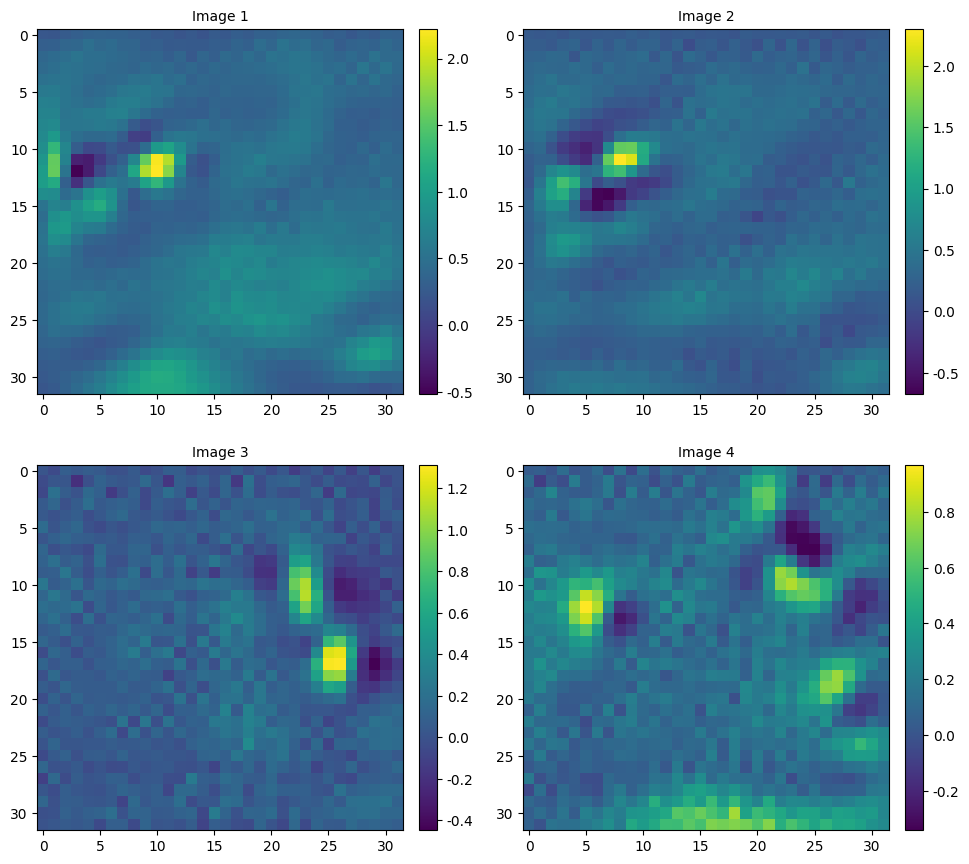

In [8]:
save_image(x0, inf_image[0], inf_image[1], inf_image[2],show=True)
save_image(inf_image[3], inf_image[4], inf_image[5], inf_image[6], show=True)

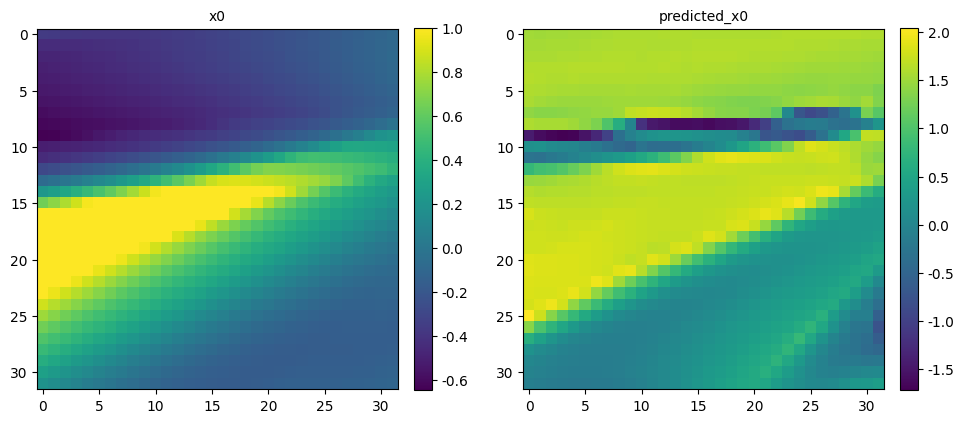

In [15]:
save_image(x0, inf_image[45,:,:,:], 
           names=['x0', 'predicted_x0'], show=True)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

n = len(inf_image_list)
acc_matrix = np.zeros((n, n))

# 生成完整矩阵
for i in range(n):
    for j in range(n):
        acc_matrix[i, j] = fucs.cal_acc(inf_image_list[i][0], inf_image_list[j][0])

# 创建掩码（隐藏上三角，包含对角线）
mask = np.triu(np.ones_like(acc_matrix, dtype=bool), k=1)
colors = ["#023858", "#3690c0", "#ffffff", "#ef6548", "#990000"]  # 深蓝→浅蓝→白→浅红→深红
nodes = [-1.0, -0.5, 0.0, 0.5, 1.0]  # 颜色控制节点
cmap = LinearSegmentedColormap.from_list("sym_cmap", list(zip(np.linspace(0,1,5), colors)), N=256)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    acc_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    mask=mask,
    center=0,  # 颜色中心点
    vmin=-1,   # 强制颜色范围
    vmax=1,
    square=True,
    linewidths=0.5,
    linecolor='lightgray',
    cbar_kws={'label': 'ACC'},
    annot_kws={'color': 'black', 'weight': 'bold'}  # 数值颜色加强对比
)

# 优化坐标轴
ax.set_xticks(np.arange(n)+0.5, minor=True)
ax.set_yticks(np.arange(n)+0.5, minor=True)
ax.grid(which="minor", color="white", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)

plt.xlabel('Index j')
plt.ylabel('Index i')
# plt.title('Lower Triangle Correlation Matrix')
plt.tight_layout()
plt.show()

In [11]:
acc_tensor = torch.tensor(acc_matrix)
avg_sim = torch.mean(acc_tensor, dim=0)
print("平均准确率:", avg_sim)

NameError: name 'acc_matrix' is not defined

In [ ]:
save_image(acc_tensor, show=True)

In [16]:
plt.plot(avg_sim)

NameError: name 'avg_sim' is not defined

In [19]:
threshold = 0.13
selected_idx_thresh = torch.nonzero(avg_sim > threshold, as_tuple=False).view(-1).tolist()
print(f"Number of indices above threshold: {len(selected_idx_thresh)}")
print(selected_idx_thresh)

Number of indices above threshold: 37
[0, 1, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 47, 49]


In [20]:
K = 5
# 按 avg_sim 排序并取最大的 K 个索引
_, sorted_idx = torch.sort(avg_sim, descending=True)
selected_idx_topk = sorted_idx[:K].tolist()
print(f"平均相似度前 {K} 的预测样本索引列表：\n{selected_idx_topk}")

平均相似度前 5 的预测样本索引列表：
[47, 33, 36, 25, 45]


In [27]:
def fuse_by_weighted_average(preds: list, indices: list, similarities: torch.Tensor) -> torch.Tensor:
    """
    对 preds[indices] 对应的预测图像，按 similarities（长度=N）中对应的值做归一化加权平均。
    返回 fused: Tensor shape (1,1,32,32)
    """
    sel_sims = similarities[indices]  # (M,)
    # 只取正值部分（为防万一，如果有负值，将其置为0）
    sel_sims_clipped = torch.clamp(sel_sims, min=0.0)
    if sel_sims_clipped.sum() < 1e-6:
        # 如果所有权重都接近 0，则退化为简单平均
        weights = torch.ones_like(sel_sims_clipped) / len(sel_sims_clipped)
    else:
        weights = sel_sims_clipped / sel_sims_clipped.sum()  # 归一化权重 (M,)
    # 将 preds 中对应索引的图像堆叠
    stacked = torch.cat([preds[i] for i in indices], dim=0)  # (M,1,32,32)
    # 先将 weights 扩展到图像形状 (M,1,32,32)
    w_expand = weights.view(-1, 1, 1, 1)  # (M,1,1,1)
    fused = (stacked.cpu() * w_expand).sum(dim=0, keepdim=True)  # (1,1,32,32)
    return fused

preds = inf_image_list
# 使用“阈值筛选”结果进行加权平均融合
if len(selected_idx_thresh) > 0:
    fused_thresh = fuse_by_weighted_average(preds, selected_idx_thresh, avg_sim)
    print("使用阈值筛选后融合得到的图像 shape:", fused_thresh.shape)
else:
    print(f"没有满足平均相似度 > {threshold} 的样本，无法融合。")

# 使用“Top-K 筛选”结果进行加权平均融合
fused_topk = fuse_by_weighted_average(preds, selected_idx_topk, avg_sim)
print("使用 Top-K 筛选后融合得到的图像 shape:", fused_topk.shape)

使用阈值筛选后融合得到的图像 shape: torch.Size([1, 1, 32, 32])
使用 Top-K 筛选后融合得到的图像 shape: torch.Size([1, 1, 32, 32])


In [29]:
cal_acc(fused_thresh[0], x0[0].cpu())

tensor([0.7041], dtype=torch.float64)

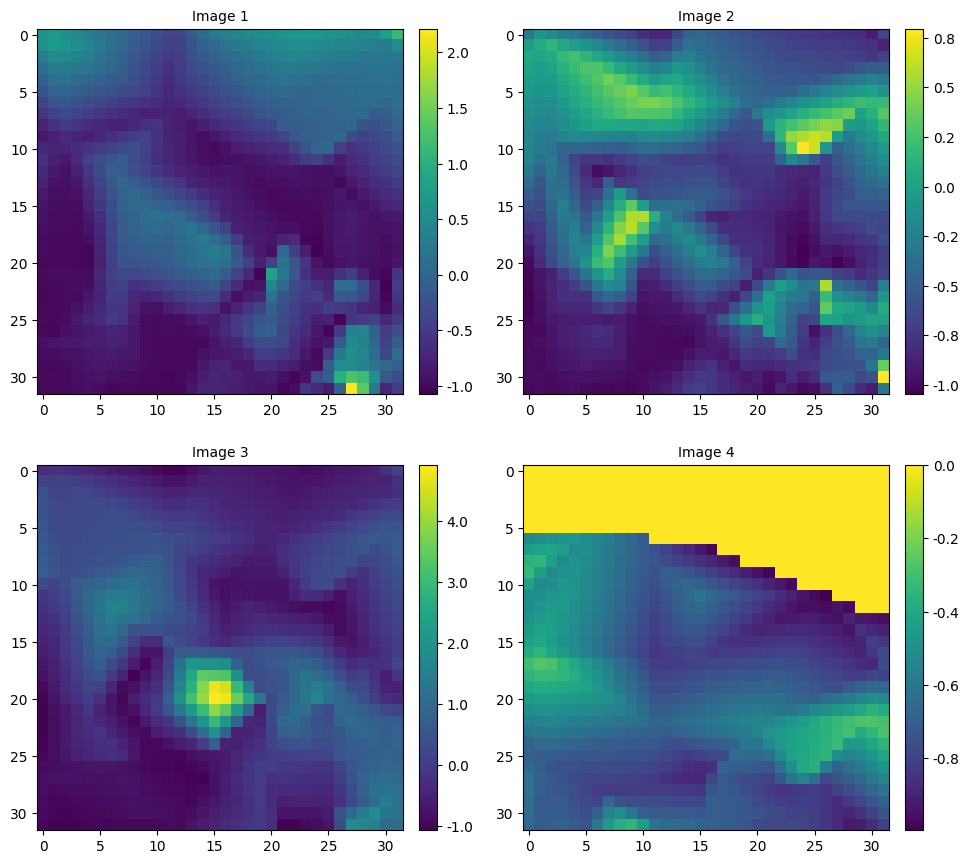

In [30]:
save_image(preds[1], preds[22], preds[28], x0, show=True)

In [19]:
N = 100
H, W = 32, 32

In [20]:
data = np.zeros((N, H * W), dtype=np.float32)
for i in range(inf_image.shape[0]):
    data[i] = inf_image[i].flatten().cpu()
print(data.shape)

(100, 1024)


C:\Users\fired\AppData\Local\Temp\ipykernel_19340\1416302755.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data[i] = inf_image[i].flatten().cpu()


In [21]:
from sklearn.cluster import KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(data)  # labels.shape = (N,)，取值在 [0, n_clusters-1]
counts = np.bincount(labels, minlength=n_clusters)
for cluster_id, count in enumerate(counts):
    print(f"簇 {cluster_id} 的样本数量: {count}")

簇 0 的样本数量: 43
簇 1 的样本数量: 41
簇 2 的样本数量: 16


In [22]:
selected_indices0 = np.where(labels == 0)[0].tolist()
selected_indices1 = np.where(labels == 1)[0].tolist()
selected_indices2 = np.where(labels == 2)[0].tolist()
mean1 = inf_image[selected_indices1].mean(axis=0)
mean2 = inf_image[selected_indices2].mean(axis=0)
mean0 = inf_image[selected_indices0].mean(axis=0)

acc01 = fucs.cal_acc(mean0, mean1)
acc12 = fucs.cal_acc(mean1, mean2)
acc02 = fucs.cal_acc(mean0, mean2)

print(acc01, acc12, acc02)

tensor([0.5543], device='cuda:0') tensor([-0.8433], device='cuda:0') tensor([-0.3095], device='cuda:0')


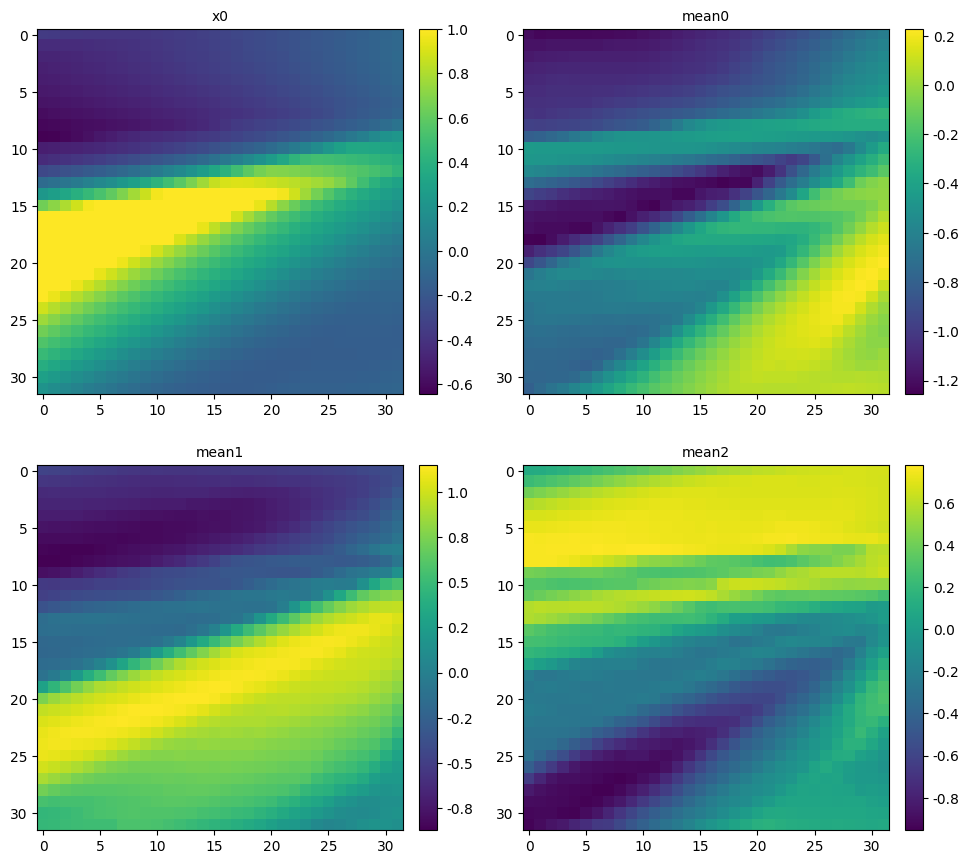

In [23]:
save_image(x0, mean0, mean1, mean2, names=['x0', 'mean0', 'mean1', 'mean2'], show=True)


In [ ]:
selected_indices = np.where(labels == 2)[0].tolist()
print(selected_indices)
print(len(selected_indices))

In [ ]:
# 4. 对最大簇内样本做像素均值融合（全用torch）
if len(selected_indices) > 0:
    fused_image = inf_image[selected_indices].mean(dim=0)  # shape: [1, 32, 32]
    print("融合后图像的 shape:", fused_image.shape)
else:
    print("最大簇中没有样本，无法融合。")

C:\Users\fired\AppData\Local\Temp\ipykernel_17332\379751439.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  save_image(torch.tensor(fused_image), names=['direct'], show=True)


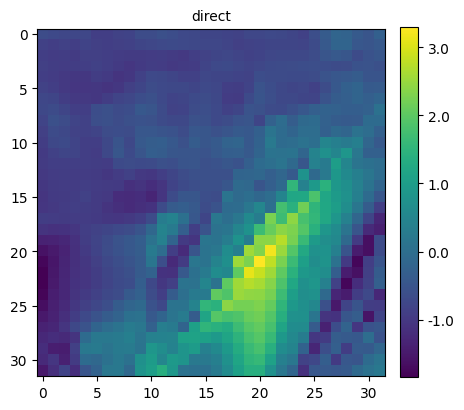

In [84]:
save_image(torch.tensor(fused_image), names=['direct'], show=True)

In [24]:
print(cal_acc(mean0, x0[0]))
print(cal_acc(mean1, x0[0]))
print(cal_acc(mean2, x0[0]))


tensor([-0.1029], device='cuda:0')
tensor([0.6493], device='cuda:0')
tensor([-0.5587], device='cuda:0')


In [84]:
preds2 = [inf_image_list[i].cpu() for i in selected_indices]

In [86]:
data2 = np.zeros((len(preds2), H * W), dtype=np.float32)
for i, arr in enumerate(preds2):
    data2[i] = arr.flatten().cpu()
print(data2.shape)

(9, 1024)


C:\Users\fired\AppData\Local\Temp\ipykernel_2680\1066246743.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data2[i] = arr.flatten().cpu()


In [97]:

kmeans2 = KMeans(n_clusters=2, random_state=0)
labels2 = kmeans2.fit_predict(data2)  # labels.shape = (N,)，取值在 [0, n_clusters-1]
counts2 = np.bincount(labels2, minlength=n_clusters)
for cluster_id, count in enumerate(counts2):
    print(f"簇 {cluster_id} 的样本数量: {count}")
selected_indices = np.where(labels2 == 1)[0].tolist()
print(selected_indices)

簇 0 的样本数量: 8
簇 1 的样本数量: 1
[7]
